# Advanced Statistical Inference -- Bayesian Linear Regression 

In this session, you'll start to implement some basic Bayesian models, 
starting from the simple Bayesian linear regression.

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt
import warnings
import scipy.linalg
import scipy.stats
warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)

# 1. A regression dataset
Create a simple 1D regression dataset using the `make_regression(...)` function and plot it.
For the moment, keep the noise variance $\sigma_\mathrm{n}$ small.
NB. For better reproducibility, please remember to fix the Numpy's random seed. 
For Jupyter notebooks, this needs to be done at the beginning of all cells.

In [2]:
def make_regression(n: int, sigma2noise: float = .1):
    X = np.random.uniform(-3, 3, n)
    y = 5 - .25 * X  + 0.5 * X ** 3 
    y += np.sqrt(sigma2noise) * np.random.randn(*X.shape)
    return X[:, None], y

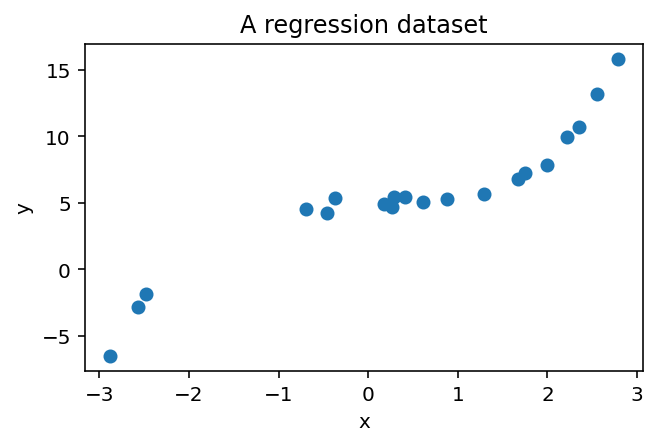

In [3]:
set_seed()
sigma2noise = .1
X, y = make_regression(20, sigma2noise=sigma2noise)

fig, ax = plt.subplots(figsize=[5,3])
ax.plot(X, y, 'o')
ax.set_title('A regression dataset')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.margins(0.05)
plt.show()

# 2. A review on Gaussian likelihood
Let's start from the basics. Remember what a likelihood is.
The **likelihood** measures the goodness of fit of a statistical model to samples of data for given values of 
the unknown model parameters.
It's computed from the joint probability distribution, but viewed and used as **function** 
of the parameters only, thus treating the random variables as fixed at the observed values.

A Gaussian likelihood is defined as 

\begin{equation}
p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \prod_{i=1}^N p(y_i|\mathbf{w}, {\mathbf{x}}_i, \sigma_\mathrm{n}) = \prod_{i=1}^N \mathcal{N}(y_i|\tilde y_i, \sigma_\mathrm{n})
\end{equation}

where, for linear regression, $\tilde y_i = \mathbf{w}^\top {\mathbf{x}}_i$.
For numerical stability, instead of using the vanilla likelihood, we will use the **log-likelihood**.

\begin{equation}
\log p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) =  \sum_{i=1}^N  \log\mathcal{N}(y_i|\tilde y_i, \sigma_\mathrm{n})
\end{equation}

**Exercise:**
Write a function to compute the log-density of a normal distribution at position $x$, given $\mu$ and $\sigma^2$.

In [4]:
def lognormal(x, mu, va):
    return -np.log(va)-1/2*np.log(2*np.pi)-(x-mu)**2/(2*va**2)

**Exercise:**
For the moment, assume that for the sample $i^{\mathrm{th}}$, you predict $\tilde y = 0.3$ and $\sigma_\mathrm{n} = 1$. 
You know that $y = 0.4$. 
Complete the following function `gaussian_loglik(...)`, then compute the (log)likelihood for this sample and show its position on the Gaussian density with a plot.

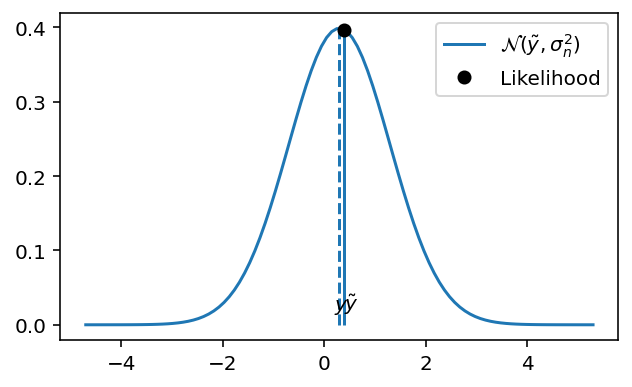

In [5]:
def gaussian_loglik(y, y_tilde, sigma2noise):
    return lognormal(y, y_tilde, sigma2noise)


def plot_gaussian(mu: np.ndarray, var: np.ndarray, plot_log: bool = False, **kwargs):
    """ A simple util to plot a gaussian pdf """
    x = np.linspace(mu - 5 * np.sqrt(var), mu + 5 * np.sqrt(var), 100)
    y = lognormal(x, mu, var) if plot_log else np.exp(lognormal(x, mu, var))
    ax = kwargs.pop('ax', plt.gca())
    ax.plot(x, y, **kwargs)
    return ax


y_obs =        0.4
y_tilde =      0.3
sigma2noise =  1

sample_logl =  gaussian_loglik(y_obs, y_tilde, sigma2noise)

fig, ax = plt.subplots(figsize=[5, 3])
plot_gaussian(y_tilde, sigma2noise, ax=ax, label=r'$\mathcal{N}(\tilde y, \sigma_n^2)$')
ax.vlines(y_obs, 0, np.exp(sample_logl))
ax.vlines(y_tilde, 0, np.exp(gaussian_loglik(y_tilde, y_tilde, sigma2noise)), ls='--')
ax.plot(y_obs, np.exp(sample_logl), 'ok', label=r'Likelihood')
ax.text(y_tilde+0.1, 0.02, r'$\tilde y$')
ax.text(y_obs-0.2, 0.02, r'$y$')
ax.legend()
plt.show()

# 3. Bayesian Linear regression

In this section, you'll start to implement the Bayesian linear regression model.
Let's start by creating the **design matrix** $\mathbf{X}$.

$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$$

**Exercise:**
Complete the following function `build_X(...)` to build $\mathbf{X}$.
This can be done in many ways. One of them is using a double list comprehension (one index for the row and one for the column), while another one is using the numpy `column_stack()` function (highly suggested). In any case, inspect $\mathbf{X}$ to make sure it looks OK (show the first entries). To fit higher order polynomials, we need to add extra columns to $\mathbf{X}$, therefore build it with $K$ as a parameter.

In [6]:
def build_X(X, K):
    assert K > 0 and isinstance(K, int)
    L = tuple([np.reshape(X**i, len(X)) for i in range (K+1)])
    return np.column_stack(L)

build_X(X, 2)[:5]

array([[ 1.        ,  0.29288102,  0.08577929],
       [ 1.        ,  1.2911362 ,  1.66703268],
       [ 1.        ,  0.61658026,  0.38017121],
       [ 1.        ,  0.2692991 ,  0.072522  ],
       [ 1.        , -0.4580712 ,  0.20982923]])

From the lecture notes, let's define the prior on the parameters $\mathbf{w}$ as 

\begin{equation}
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \mathbf{S}) 
\end{equation}

For sake of simplicity, assume the covariance matrix $\mathbf{S}$ to be diagonal $\mathbf{S} = \sigma_\mathrm{w}^2\mathbf{I}$.
Remember that the likelihood is defined as $p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \mathcal{N}(\mathbf{y}|\mathbf{X}\mathbf{w}, \sigma_\mathrm{n}^2\mathbf{I})$.
In this case, the posterior is analitic and follows this form:

\begin{equation}
p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) = \mathcal{N}\left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{\Sigma}\mathbf{X}^\top\mathbf{y}, \mathbf{\Sigma} \right)
\end{equation}
where $\mathbf{\Sigma}^{-1} = \left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}  \right)$.

**Question:** What is the dimensionality of $\mathbf{\Sigma}$? How much does it cost to compute that inverse? Do you know which algorithm you should use to have numerically stable results? Remember that computing $\mathbf{A}^{-1}\mathbf{z}$ means in practice solving a linear system.

**Exercise:** Complete the following function to compute the posterior. Use the numerical sable algorithm (avoid `np.linalg.inv` on the full covariance).

In [8]:
def compute_posterior(X, y, sigma2priorweights, sigma2noise):
    Sigma_inverse =    1/sigma2noise*X.T@X + np.diag([sigma2priorweights]*len(X[0]))
    posterior_mu = np.linalg.solve(Sigma_inverse, X.T@y)/sigma2noise
    posterior_Sigma = np.linalg.solve(Sigma_inverse, np.identity(len(Sigma_inverse)))
    #posterior_Sigma =  np.linalg.inv(Sigma_inverse)  #to CHANGE
    return posterior_mu, posterior_Sigma

**Exercise:** Compute the posterior for the regression dataset. For the moment, place $\sigma_\mathrm{w}^2=1$ and start with polynomial of order 1. Finally, print the posterior mean and covariance. Comment the results.

In [9]:
sigma2priorweights = 1
K = 1

bigX = build_X(X,K)
w_posterior_mu, w_posterior_Sigma = compute_posterior(bigX, y, sigma2priorweights, sigma2noise)  # TO COMPLETE

In [10]:
w_posterior_mu

array([3.9743238 , 2.80545053])

In [11]:
w_posterior_Sigma

array([[ 0.05149445, -0.00831582],
       [-0.00831582,  0.01784406]])

**Exercise:** Visualize the prior and the posterior on a 3D plot.

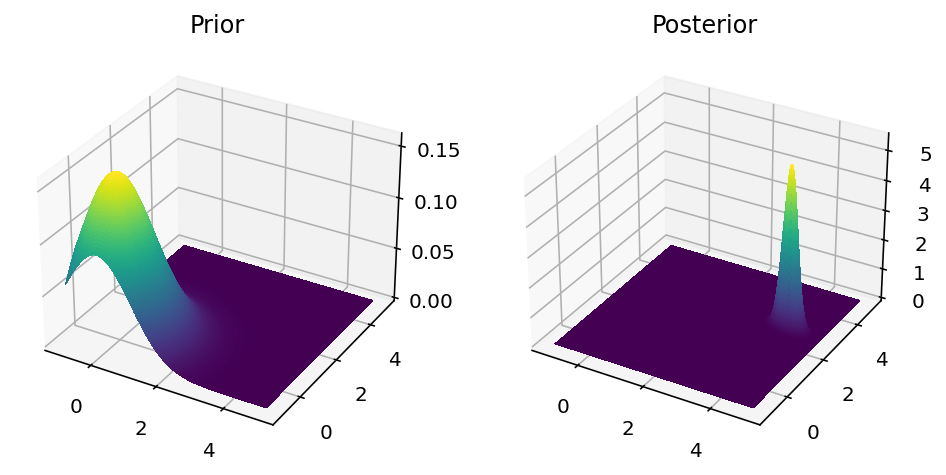

In [12]:
x_ = np.linspace(-1, 5, 500)
y_ = np.linspace(-1, 5, 500)
X_, Y_ = np.meshgrid(x_,y_)
pos = np.empty(X_.shape + (2,))
pos[:, :, 0] = X_; pos[:, :, 1] = Y_


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

rv = scipy.stats.multivariate_normal(np.zeros(2), np.eye(2))
ax.plot_surface(X_, Y_, rv.pdf(pos),cmap='viridis',linewidth=0, antialiased=False, ccount=200, rcount=200)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_title('Prior')

ax = fig.add_subplot(1, 2, 2, projection='3d')
rv = scipy.stats.multivariate_normal(w_posterior_mu, w_posterior_Sigma)
ax.plot_surface(X_, Y_, rv.pdf(pos),cmap='viridis',linewidth=0, antialiased=False, rcount=500, ccount=500)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')

ax.set_title('Posterior')
plt.show()

# 4. Predictions
Now it's time to make predictions. 
All our motivation for being Bayesian was to be able to average predictions at $\mathbf{x}_\mathrm{new}$, for all possible $\mathbf{w}$.
This is possible by computing the following expectation:


\begin{equation}
\mathbf{E}_{p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n})}\mathcal{N}(\mathbf{w}^\top\mathbf{x}_\mathrm{new}, \sigma^2_\mathrm{n}) = \int \mathcal{N}(\mathbf{w}^\top\mathbf{x}_\mathrm{new}, \sigma^2_\mathrm{n}) p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) \mathrm{d}\mathbf{w}
\end{equation}


**Question:** Prove that 
$\mathbf{E}_{p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n})}\mathcal{N}(\mathbf{w}^\top\mathbf{x}_\mathrm{new}, \sigma^2_\mathrm{n}) = 
\mathcal{N}(\mathbf{x}_\mathrm{new}^\top\mathbf{\mu}, \sigma^2_\mathrm{n} + \mathbf{x}_\mathrm{new}^\top\mathbf{\Sigma}\mathbf{x}_\mathrm{new})$, where $\mathbf{\mu}$ and $\mathbf{\Sigma}$ are the posterior mean and covariance.

**Exercise:** Write a function to compute the predictive distribution.

In [24]:
def compute_predictive(Xnew, w_posterior_mu, w_posterior_Sigma, sigma2noise):
    K = w_posterior_Sigma.shape[0] - 1
    Xnew = build_X(Xnew, K)
    y_posterior_mu = Xnew@w_posterior_mu
    y_posterior_Sigma = sigma2noise + Xnew@w_posterior_Sigma@Xnew.T

    return y_posterior_mu, y_posterior_Sigma

**Exercise:** Compute and plot the predictive distribution for 100 points between -4 and +4.

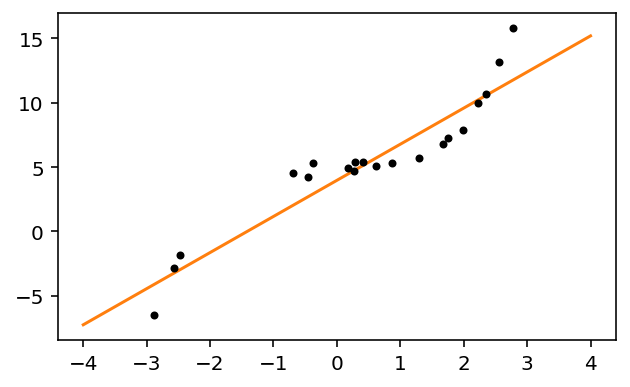

In [25]:
Xtest = np.linspace(-4, 4, 100)[...,None]
y_posterior_mu, y_posterior_sigma2 = compute_predictive(Xtest, w_posterior_mu, w_posterior_Sigma, sigma2noise)  


fig, ax = plt.subplots(figsize=[5, 3])
ax.plot(X, y, '.k', zorder=100)
ax.plot(Xtest, y_posterior_mu, color='C1')

#lb = y_posterior_mu - 3 * np.sqrt(y_posterior_sigma2)
#ub = y_posterior_mu + 3 * np.sqrt(y_posterior_sigma2)
#ax.fill_between(Xtest[...,0], lb, ub, color='C1', alpha=0.4, lw=0);
plt.show()

**Exercise:** You can also sample from the predictive posterior. 
<!-- In general, a sample from a Normal distribution $\hat x \sim \mathcal{N}(x|\mu, \sigma^2)$ can be build as follows

\begin{equation}
\hat x = \mu + \varepsilon \sigma\,,\quad \mathrm{where} \quad \varepsilon \sim \mathcal{N}(0, 1)
\end{equation}

This is known as *reparameterization trick*. Try to sample 20 times the predictive posterior and plot it. 
Try to implement yourself the reparameterization trick (`np.random.randn()` returns a sample from a standard normal with 0 mean and unit variance). -->

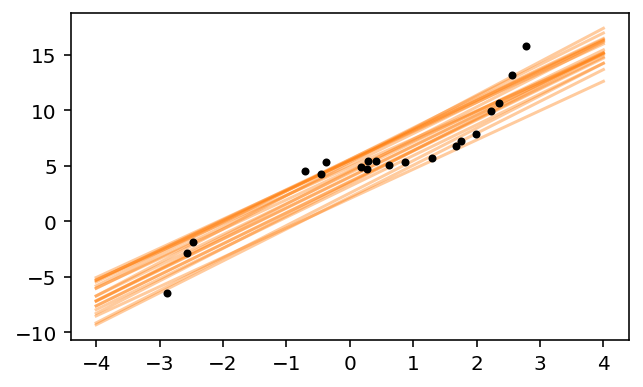

In [26]:
set_seed()

Xtest = np.linspace(-4, 4, 100)[...,None]
y_posterior_mu, y_posterior_sigma2 = compute_predictive(Xtest, w_posterior_mu, w_posterior_Sigma, sigma2noise)  

fig, ax = plt.subplots(figsize=[5, 3])
ax.plot(X, y, '.k', zorder=100)
for _ in range(20):
    sample_ = np.random.multivariate_normal(y_posterior_mu, y_posterior_sigma2)    # TO COMPLETE
    ax.plot(Xtest, sample_, 'C1', alpha=0.4)
plt.show()

**Exercise**: Try now with different polynomial order. Let's say 2, 3, 5, 10. Compute the design matrix, the posterior on $\mathbf{w}$ and the predictive posterior. What do you observe?

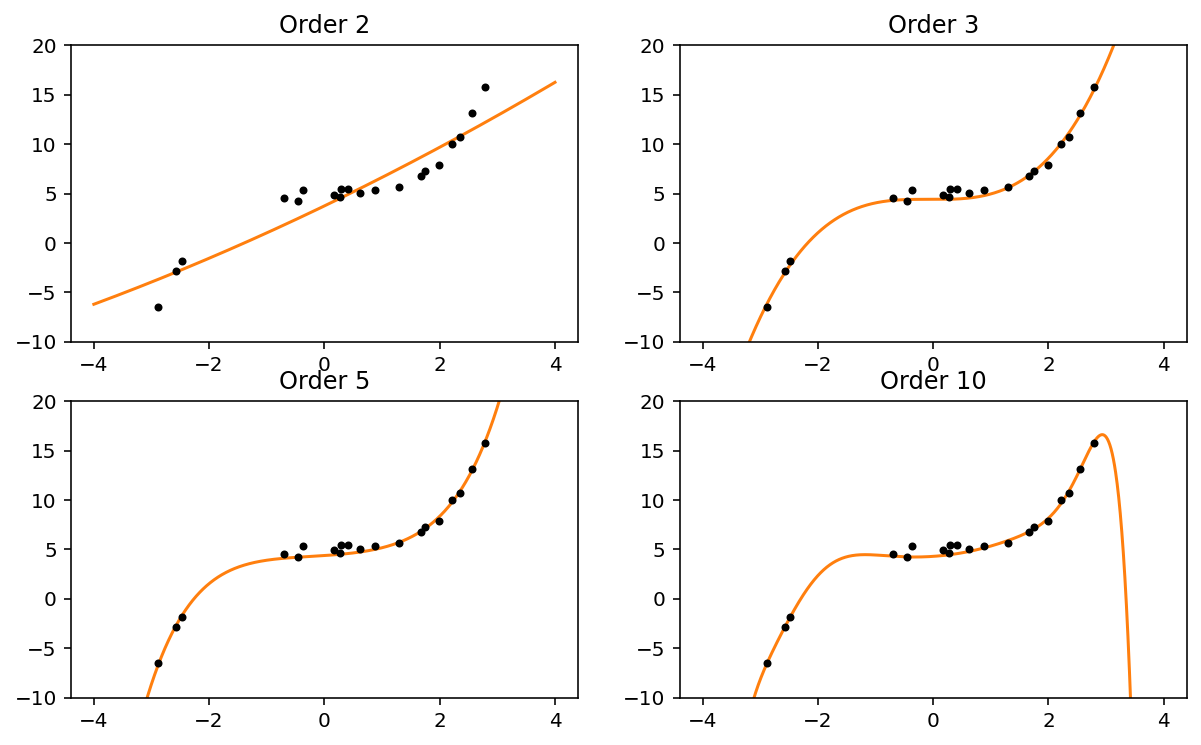

In [27]:
poly_orders = [2, 3, 5, 10]
Xtest = np.linspace(-4, 4, 1200)[...,None]

fig, axs = plt.subplots(2, 2, figsize=[10, 6])
axs = axs.reshape(-1)
for i, K in enumerate(poly_orders):
    ax = axs[i]
    bigX = build_X(X,K)
    w_posterior_mu, w_posterior_Sigma =  compute_posterior(bigX, y, sigma2priorweights, sigma2noise)
    y_posterior_mu, y_posterior_sigma2 = compute_predictive(Xtest, w_posterior_mu, w_posterior_Sigma, sigma2noise)  
    #lb = y_posterior_mu - 3 * np.sqrt(y_posterior_sigma2)
    #ub = y_posterior_mu + 3 * np.sqrt(y_posterior_sigma2)
    
    ax.plot(Xtest, y_posterior_mu, color='C1')
    ax.plot(X, y, '.k', zorder=100)
    #ax.fill_between(Xtest[...,0], lb, ub, color='C1', alpha=0.4, lw=0);
    ax.set_ylim(-10, 20)
    ax.set_title('Order %d' % K)
plt.show()

# 5. Evaluate you model: the marginal likelihood

There are several ways in which you can compute the goodness of your model. The first is the likelihood itself.

**Question:** Compute the mean loglikelihood for model with order from 1 to 7 and plot it. Comment the results.

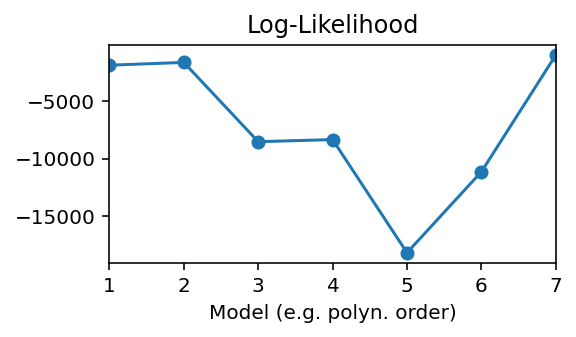

In [34]:
def gaussian_loglik_multi(y, y_tilde, sigma2noise):
    s=0
    for i in range(len(y)):
        s+= lognormal(y[i], y_tilde[i], sigma2noise)
    return s

poly_orders = range(1, 8)
mll = []
for i, K in enumerate(poly_orders):
    bigX = build_X(X, K)
    w_posterior_mu, w_posterior_Sigma = compute_posterior(bigX, y, sigma2priorweights, sigma2noise)
    y_posterior_mu, _ = compute_predictive(Xtest, w_posterior_mu, w_posterior_Sigma, sigma2noise) 
    mll_ = gaussian_loglik_multi(y, y_posterior_mu, sigma2noise)

    mll.append(mll_)

fig, ax = plt.subplots(figsize=[4,2])
ax.plot(poly_orders, mll, '-oC0')
ax.margins(0, 0.05)
ax.set_title('Log-Likelihood');
ax.set_xlabel('Model (e.g. polyn. order)')
plt.show()

**Question:** Try to answer: How likely is $\mathbf{y}$ given $\mathbf{X}$ *and* the model (‘first/second/... order polynomial’)? Is it the same likelihood as before?

So far, we’ve ignored $p(\mathbf{y}|\mathbf{X}, \sigma^2_\mathrm{n})$, the normalising thing in Bayes rule. Being a normalization constant, it has to be equal to 

\begin{equation}
p(\mathbf{y}|\mathbf{X}, \sigma^2_\mathrm{n}) = \int p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma^2_\mathrm{n})
p(\mathbf{w})\mathrm{d}\mathbf{w}
\end{equation}

We’re averaging over all values of $\mathbf{w}$ to get a value for how good the model is.

**Question:** Suppose the prior being $\mathcal{N}(\mu_0, \mathbf{\Sigma}_0)$ and the likelihood $\mathcal{N}(\mathbf{X}\mathbf{w}, \sigma^2_\mathrm{n} \mathbf{I})$. Derive the marginal likelihood (hint: don't solve the integral -- check the rules for Gaussian conditioning and marginalization) (big hint: check the lecture notes).

**Exercise:** Write a function to compute the marginal likelihood. Remember: this is a *likelihood* not a density. You should return a number not a density. For simplicity, assume $\mu_0 = 0$ and $\Sigma_0 = \sigma^2_\mathrm{w}\mathbf{I}$. Use `scipy.stats.multivariate_normal` for computing the logpdf.

In [42]:
from scipy.stats import multivariate_normal

def marginal_likelihood(X, y, sigma2w, sigma2noise):
    return scipy.stats.multivariate_normal.pdf(y,np.zeros(np.shape(X)),
                                           sigma2noise*np.identity(X.shape[0]) + sigma2w*X@np.identity(X.shape[1])@X.T)

**Exercise:** Do the sample plot as before, but now plot the marginal likelihood. You should see a clear pattern here; comment the result.

In [43]:
poly_orders = range(1, 8)
mll = []
for i, K in enumerate(poly_orders):
    bigX = build_X(X, K)
    w_posterior_mu, w_posterior_Sigma = compute_posterior(bigX, y, sigma2priorweights, sigma2noise)
    y_posterior_mu, _ = compute_predictive(Xtest, w_posterior_mu, w_posterior_Sigma, sigma2noise) 
    mll_ =   marginal_likelihood(bigX, y_posterior_mu, sigma2priorweights,sigma2noise)
    mll.append(mll_)

fig, ax = plt.subplots(figsize=[5,2])
ax.plot(poly_orders, mll, '-oC0')
ax.margins(0, 0.05)
ax.set_title('Log-Marginal Likelihood');
ax.set_xlabel('Model (e.g. polyn. order)')
plt.show()

ValueError: Array 'mean' must be a vector of length 40.

# 6. When polynomial features are not enough (++)

In [ ]:
import os, requests, zipfile, io
from shutil import copyfile, rmtree
def snelson1d(path):
    path = os.path.expanduser(path)
    inputs_path = os.path.join(path, 'snelson_train_inputs')
    outputs_path = os.path.join(path, 'snelson_train_outputs')

    # Contains all source as well. We just need the data.
    url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

    if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(path)

        # Copy the required data
        copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
        copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

        # Clean up everything else
        rmtree(os.path.join(path, "SPGP_dist"))
    

    X = np.loadtxt(os.path.join(inputs_path))[:, None]
    Y = np.loadtxt(os.path.join(outputs_path))[:, None]

    return X, Y

X, Y = snelson1d('./data')
Y.shape

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.plot(X , Y, 'k.')
ax.set_title('Snelson dataset')
ax.set_xlim(-3, 9)
ax.set_ylim(-3, 3)
plt.show()

Just from looking at the dataset, you can imagine that fitting this dataset will be hard. And it is (with polynomial features).
Maybe it becomes easier with different type of features.
Remember that you can choose whatever you want to build the design matrix. Take a look at the following 

$$
\mathbf{X} = \sqrt{\frac{\alpha^2}{K}}\left[ 
    {\begin{array}{cccccc}
         \cos(\omega_1x_1) &  \sin(\omega_1x_1) & \dots &   \cos(\omega_Kx_1) & \sin(\omega_Kx_1) \\
         \cos(\omega_1x_2) &  \sin(\omega_1x_2) & \dots &   \cos(\omega_Kx_2) & \sin(\omega_Kx_2) \\
         \vdots &  \vdots &       &   \vdots  \\
          \cos(\omega_1x_N) &  \sin(\omega_1x_N) & \dots &   \cos(\omega_Kx_N) & \sin(\omega_Kx_N) \\
  \end{array} } 
\right]
\quad
\mathrm{where}
\quad 
\omega_i \sim \mathcal N (0, \lambda)
$$

Now, the next formulation of the design matrix $\mathbf{X}$ might seems to come completely out of the blue, but it's not (for those of you interested, this is the random feature expansion of the RBF kernel -- join the next lecture to know more).

For simplicity below you have the code to compute $\mathbf{X}$.

**Exercise:** Now run Bayesian linear regression on this dataset with this new set of features (NB. You might need many MANY features)

In [ ]:
set_seed()

omega = np.random.randn(10000)/.5
def build_X(X: np.ndarray, K: int):
    assert K >= 0 and isinstance(K, int)
    
    X_ =  np.column_stack([np.sin(X * omega[k]) for k in range(K//2+1)])
    Z_ =  np.column_stack([np.cos(X * omega[k]) for k in range(K//2)])
    X_ =  np.concatenate([X_, Z_], -1) 
    return X_ * np.sqrt(1/K)


Xtest = np.linspace(X.min()-3, X.max()+5, 500)
n_features = [1*2, 5*2, 100*2, 2500*2]

fig, axs = plt.subplots(4, 1, figsize=[6, 12])
axs = axs.reshape(-1)
for i, K in enumerate(n_features):
    ax = axs[i]
   
    bigX = build_X(X, K)


    w_posterior_mu, w_posterior_Sigma = # TO COMPLETE
    # TO COMPLETE
    
    ax.plot(X , Y, 'k.')
    # TO COMPLETE
 
    ax.set_title('Regression with %d random features' % (K//2))

plt.show()

# 7. A more complex model: being Bayesian on the noise (++)

Now we are ready spice things up! Everything we did, we did it assuming that the noise variance $\sigma_\mathrm{n}^2$ was known. This is a far too restrictive assumption in practice. 
There are several ways to choose $\sigma_\mathrm{n}^2$ (cross-validation, maximization of the marginal likelihood w.r.t. $\sigma_\mathrm{n}^2$, ...).
But this -- being a course on Bayesian inference -- requires to develop a solution in a "Bayesian" way: place a prior on $\sigma_\mathrm{n}^2$ and infer a posterior given some data.

As usual, the likelihood has the form $p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \mathcal{N}(\mathbf{X}\mathbf{w}, \sigma^2_\mathrm{n} \mathbf{I})$.

One can show that the natural conjugate prior is a normal-inverse Gaussian distribution with the following form:

\begin{align}
p(\mathbf{w}, \sigma^2_\mathrm{n})  &= \mathrm{NIG}(\mathbf{w}, \sigma^2_\mathrm{n}|\mu_0, \mathbf{\Sigma}_0, a_0, b_0) = \\
                                    &= \mathcal{N}(\mathbf{w}|\mu_0,\sigma^2_\mathrm{n}\mathbf{\Sigma}_0)\mathrm{IG}(\sigma^2_\mathrm{n}|a_0, b_0)
\end{align}

where IG is the inverse Gamma distribution.

**Exercise:** Since changes are you never saw an inverse Gamma distribution, use the following cell to play with it. Try to change the parameters $a_0$ and $b_0$. What happens if you both set them to 0?

In [ ]:
a0, b0 = 1, 3
rv = scipy.stats.invgamma(a=a0, scale=b0)

fig, ax = plt.subplots(figsize=[4, 2.5])
xplot = np.linspace(0, 10, 100)
ax.plot(xplot, rv.pdf(xplot))
ax.set_title('IG(%.1f,%.1f)' % (a0,b0))
plt.show()

One can derive the posterior $p(\mathbf{w},\sigma_\mathrm{n}^2 | \mathbf{X}, \mathbf{y})$ as follows

\begin{align}
p(\mathbf{w},\sigma_\mathrm{n}^2 | \mathbf{X}, \mathbf{y}) &= \mathrm{NIG}(\mathbf{w},\sigma_\mathrm{n}^2|\mu, \mathbf{\Sigma}, a, b)\\
\mathbf{\Sigma} &= (\mathbf{\Sigma}_0^{-1} + \mathbf{X}^\top\mathbf{X})^{-1}\\
\mu &= \mathbf{\Sigma}(\mathbf{\Sigma}_0^{-1}\mu_0 + \mathbf{X}^\top\mathbf{y}) \\
a &= a_0 + n/2 \\ 
b &= b_0 + \frac{1}{2}(\mu_0^\top\mathbf{\Sigma}_0\mu_0 + \mathbf{y}^\top\mathbf{y} - \mu^\top\mathbf{\Sigma}\mu )
\end{align}

This is left as an exercise to the reader (joking aside if you want to know more check Sec. 7.6.3.1 of "Machine Learning: A probabilistic perspective" by K.P. Murphy).
From this formulation, you can derive the two marginals on $\mathbf{w}$ and ${\sigma_\mathrm{n}^2}$, which are easier to understand.

\begin{align}
p(\sigma_\mathrm{n}^2|\mathrm{X}, \mathrm{y}) &= \mathrm{IG}(a,b)\\
p(\mathbf{w}|\mathrm{X}, \mathrm{y}) &= \mathcal{T}\left(\mu, \frac{b}{a}\Sigma, 2a\right)
\end{align}

where $\mathcal{T}$ is a student-T distribution. 

Finally, the predictive distribution a new test points $\mathbf{X}_{\mathrm{new}}$ is again a student-T distribution with the following form, 

\begin{align}
p(\mathbf{y}_\mathrm{new}| \mathbf{X}_\mathrm{new}, \mathbf{X}, \mathbf{y}) = \mathcal{T}\left(\mathbf{X}_\mathrm{new}\mu, \frac{b}{a}(I + \mathbf{X}_\mathrm{new}\mathbf{\Sigma}\mathbf{X}_\mathrm{new}^\top), 2a \right)
\end{align}

**Exercise:** Write the function to compute the posterior following the formula above. Compute also the predictive posterior and plot few samples from it. Start with order 1. 
<!-- NB: A sample from the student-T distribution can be constructed using the *reparameterization trick* similarly to the Gaussian,

\begin{equation}
\hat x = \mu + \varepsilon \sigma\,,\quad \mathrm{where} \quad \varepsilon \sim \mathcal{T}(0, 1, \mathrm{dof})
\end{equation} -->

For the prior, choose $\mu_0 = 0$, $\mathbf{\Sigma}_0 = \mathbf{I}$ and $a_0 = b_0 = 0$.

In [ ]:
set_seed()
sigma2noise = .1
X, y = make_regression(20, sigma2noise=sigma2noise)
Xtest = np.linspace(-4, 4, 100)[...,None]

def build_X(X: np.ndarray, K: int):
    return np.column_stack([X ** k for k in range(K+1)])

def compute_posterior(X, y, mu0, Sigma0, a0, b0):
    Sigma = # TO COMPLETE
    mu =    # TO COMPLETE 
    a =     # TO COMPLETE
    b =     # TO COMPLETE
    
    return mu, Sigma, a, b

def compute_predictive_posterior(Xnew, mu, Sigma, a, b):
    Xnew = build_X(Xnew, len(mu)-1)
    m = # TO COMPLETE
    c = # TO COMPLETE
    dof = # TO COMPLETE
    return m, np.diag(c), dof

def sample_from_student_t(m, v, dof, n):
    d = len(m)
    if dof == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(dof, n)/dof
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal

In [ ]:
set_seed()

K = 1
bigX = # TO COMPLETE
mu0 = # TO COMPLETE
Sigma0 = # TO COMPLETE
a0, b0 = 0, 0

mu, Sigma, a, b = # TO COMPLETE

m, v, dof = # TO COMPLETE

fig, ax = plt.subplots(figsize=[5, 3])
 # TO COMPLETE
ax.plot(X, y, '.k', zorder=100)
plt.show()

**Question:** Compare this plot with the previous one with order 1. Do you see any difference? Comment the results.

**Exercise:** Do the same a before, but now with order 2, 3, 5 and 10.

In [ ]:
set_seed()

poly_orders = [2, 3, 5, 10]

fig, axs = plt.subplots(2, 2, figsize=[10, 6])
axs = axs.reshape(-1)
for i, K in enumerate(poly_orders):
    ax = axs[i]
    bigX = # TO COMPLETE
    mu0 = # TO COMPLETE
    Sigma0 = # TO COMPLETE
    a0, b0 = 0, 0
    mu, Sigma, a, b = # TO COMPLETE
    m, v, dof = # TO COMPLETE
     # TO COMPLETE
    ax.set_ylim(-10, 20)
    ax.plot(X, y, '.k', zorder=100)
    ax.set_title('Order %d' % K)
    
plt.show()